# Analisis de los datos

In [90]:
import pandas as pd
import numpy as np
import boto3
import psycopg2
import configparser
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import datetime

In [2]:
config = configparser.ConfigParser()
config.read('escec.cfg')

['escec.cfg']

In [4]:
RDS_HOST = 'stocks.csg44mdgnhhv.us-east-1.rds.amazonaws.com'
postgres_driver = f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""


In [5]:
sql_query = 'SELECT * FROM dim_companies;'
df_companies = pd.read_sql(sql_query, postgres_driver)
df_companies.head()

,symbol,exchange,shortname,longname,sector,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,weight,industry
0,AAPL,NMS,Apple Inc.,Apple Inc.,Technology,134.76,2143775490048,1.305410e+11,0.081,Cupertino,CA,United States,164000.0,0.060294,Consumer Electronics
1,MSFT,NMS,Microsoft Corporation,Microsoft Corporation,Technology,239.23,1796134010880,9.798300e+10,0.124,Redmond,WA,United States,221000.0,0.050516,Software—Infrastructure
2,GOOGL,NMS,Alphabet Inc.,Alphabet Inc.,Communication Services,92.12,1197108625408,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,0.033669,Internet Content & Information
3,GOOG,NMS,Alphabet Inc.,Alphabet Inc.,Communication Services,92.80,1195709431808,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,0.033629,Internet Content & Information
4,AMZN,NMS,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,98.12,1000990834688,5.154900e+10,0.147,Seattle,WA,United States,1544000.0,0.028153,Internet Retail


### El primer analiis consite en dividir todas las acciones en 3 clusters de acuerdo al precio actual de su accion, esto nos va a servir para poder analizar cuales acciones son las de mejor desempeño y donde se puede invertir mas adelante

In [30]:
df_clusters_companies = pd.qcut(df_companies['currentprice'], q=3, labels=False)
df_cluster1 = df_companies[df_clusters_companies == 0]
df_cluster2 = df_companies[df_clusters_companies == 1]
df_cluster3 = df_companies[df_clusters_companies == 2]
df_cluster1.head()

,symbol,exchange,shortname,longname,sector,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,weight,industry
18,BAC,NYQ,Bank of America Corporation,Bank of America Corporation,Financial Services,35.23,281726550016,NaN,0.040,Charlotte,NC,United States,216823.0,0.007924,Banks—Diversified
20,PFE,NYQ,"Pfizer, Inc.",Pfizer Inc.,Healthcare,47.85,268575834112,4.352100e+10,0.468,New York,NY,United States,79000.0,0.007554,Drug Manufacturers—General
21,KO,NYQ,Coca-Cola Company (The),The Coca-Cola Company,Consumer Defensive,61.43,265341960192,1.341400e+10,0.102,Atlanta,GA,United States,79000.0,0.007463,Beverages—Non-Alcoholic
27,CSCO,NMS,"Cisco Systems, Inc.","Cisco Systems, Inc.",Technology,48.88,206156775424,1.590200e+10,-0.002,San Jose,CA,United States,83300.0,0.005798,Communication Equipment
34,CMCSA,NMS,Comcast Corporation,Comcast Corporation,Communication Services,38.93,177868062720,NaN,NaN,Philadelphia,PA,United States,189000.0,0.005003,Telecom Services


In [20]:
maxC1 = df_cluster1.describe()['currentprice'][[ 'max']][0]
maxC2 = df_cluster2.describe()['currentprice'][[ 'max']][0]
maxC3 = df_cluster3.describe()['currentprice'][[ 'max']][0]
print(f'Max C1 es:{maxC1}, Max C2 es: {maxC2}, Max C3 es: {maxC3}')

Max C1 es:74.66, Max C2 es: 154.29, Max C3 es: 4992.24


### Vamos a traer los valores con el que cerro la accion un mes atras (13 de diciembre 22)

In [25]:
sql_query = "SELECT * FROM stock_daily where id_fecha ='2022_12_13' ;"
df_stocks_20231213 = pd.read_sql(sql_query, postgres_driver)
df_stocks_20231213.head()

,id,symbol,adj_close,close,high,low,open,volume,id_fecha
0,2022_12_13_MMM,MMM,127.290001,127.290001,130.020004,126.470001,129.449997,3256900,2022_12_13
1,2022_12_13_AOS,AOS,59.369999,59.369999,60.820000,58.919998,60.560001,1135700,2022_12_13
2,2022_12_13_ABT,ABT,111.529999,111.529999,112.699997,111.059998,112.320000,6246000,2022_12_13
3,2022_12_13_ABBV,ABBV,164.789993,164.789993,167.500000,164.669998,166.949997,5050400,2022_12_13
4,2022_12_13_ACN,ACN,295.350006,295.350006,303.929993,292.929993,302.959991,3516800,2022_12_13


In [31]:
df_cluster1 = pd.merge(df_cluster1, df_stocks_20231213[['symbol', 'close']], on='symbol', how='left')
df_cluster2 = pd.merge(df_cluster2, df_stocks_20231213[['symbol', 'close']], on='symbol', how='left')
df_cluster3 = pd.merge(df_cluster3, df_stocks_20231213[['symbol', 'close']], on='symbol', how='left')
df_cluster1.head()

,symbol,exchange,shortname,longname,sector,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,weight,industry,close
0,BAC,NYQ,Bank of America Corporation,Bank of America Corporation,Financial Services,35.23,281726550016,NaN,0.040,Charlotte,NC,United States,216823.0,0.007924,Banks—Diversified,32.750000
1,PFE,NYQ,"Pfizer, Inc.",Pfizer Inc.,Healthcare,47.85,268575834112,4.352100e+10,0.468,New York,NY,United States,79000.0,0.007554,Drug Manufacturers—General,53.070000
2,KO,NYQ,Coca-Cola Company (The),The Coca-Cola Company,Consumer Defensive,61.43,265341960192,1.341400e+10,0.102,Atlanta,GA,United States,79000.0,0.007463,Beverages—Non-Alcoholic,63.990002
3,CSCO,NMS,"Cisco Systems, Inc.","Cisco Systems, Inc.",Technology,48.88,206156775424,1.590200e+10,-0.002,San Jose,CA,United States,83300.0,0.005798,Communication Equipment,49.639999
4,CMCSA,NMS,Comcast Corporation,Comcast Corporation,Communication Services,38.93,177868062720,NaN,NaN,Philadelphia,PA,United States,189000.0,0.005003,Telecom Services,36.709999


In [32]:
df_cluster1["diff"] = df_cluster1["currentprice"] - df_cluster1["close"]
df_cluster2["diff"] = df_cluster2["currentprice"] - df_cluster2["close"]
df_cluster3["diff"] = df_cluster3["currentprice"] - df_cluster3["close"]
df_cluster1.head()

,symbol,exchange,shortname,longname,sector,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,weight,industry,close,diff
0,BAC,NYQ,Bank of America Corporation,Bank of America Corporation,Financial Services,35.23,281726550016,NaN,0.040,Charlotte,NC,United States,216823.0,0.007924,Banks—Diversified,32.750000,2.480000
1,PFE,NYQ,"Pfizer, Inc.",Pfizer Inc.,Healthcare,47.85,268575834112,4.352100e+10,0.468,New York,NY,United States,79000.0,0.007554,Drug Manufacturers—General,53.070000,-5.220000
2,KO,NYQ,Coca-Cola Company (The),The Coca-Cola Company,Consumer Defensive,61.43,265341960192,1.341400e+10,0.102,Atlanta,GA,United States,79000.0,0.007463,Beverages—Non-Alcoholic,63.990002,-2.560002
3,CSCO,NMS,"Cisco Systems, Inc.","Cisco Systems, Inc.",Technology,48.88,206156775424,1.590200e+10,-0.002,San Jose,CA,United States,83300.0,0.005798,Communication Equipment,49.639999,-0.759999
4,CMCSA,NMS,Comcast Corporation,Comcast Corporation,Communication Services,38.93,177868062720,NaN,NaN,Philadelphia,PA,United States,189000.0,0.005003,Telecom Services,36.709999,2.220001


In [37]:
top_5_c1 = df_cluster1.sort_values(by='diff', ascending=False).head(5)
top_5_c1.head()

,symbol,exchange,shortname,longname,sector,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,weight,industry,close,diff
102,UAL,NMS,"United Airlines Holdings, Inc.","United Airlines Holdings, Inc.",Industrials,51.65,16724632576,3.089000e+09,0.662,Chicago,IL,United States,90800.0,0.000470,Airlines,41.169998,10.480002
104,RCL,NYQ,D/B/A Royal Caribbean Cruises L,Royal Caribbean Cruises Ltd.,Consumer Cyclical,63.48,16174068736,-1.732205e+09,41.901,Miami,FL,United States,84900.0,0.000455,Travel Services,55.759998,7.720002
14,SLB,NYQ,Schlumberger N.V.,Schlumberger Limited,Energy,58.28,81745272832,5.407000e+09,0.279,Houston,TX,United States,92000.0,0.002299,Oil & Gas Equipment & Services,51.049999,7.230001
34,NEM,NYQ,Newmont Corporation,Newmont Corporation,Basic Materials,54.35,43340591104,4.039000e+09,-0.002,Denver,CO,United States,14400.0,0.001219,Gold,47.150002,7.199998
33,DOW,NYQ,Dow Inc.,Dow Inc.,Basic Materials,58.68,43400552448,9.958000e+09,-0.049,Midland,MI,United States,35700.0,0.001221,Chemicals,51.560001,7.119999


In [36]:
top_5_c2 = df_cluster2.sort_values(by='diff', ascending=False).head(5)
top_5_c2.head()

,symbol,exchange,shortname,longname,sector,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,weight,industry,close,diff
145,UHS,NYQ,"Universal Health Services, Inc.","Universal Health Services, Inc.",Healthcare,147.88,11886135296,1.653913e+09,0.057,King of Prussia,PA,United States,89000.0,0.000334,Medical Care Facilities,129.449997,18.430003
11,NKE,NYQ,"Nike, Inc.","NIKE, Inc.",Consumer Cyclical,128.85,203946360832,7.078000e+09,0.036,Beaverton,OR,United States,79100.0,0.005736,Footwear & Accessories,112.849998,16.000002
45,VLO,NYQ,Valero Energy Corporation,Valero Energy Corporation,Energy,136.13,55654846464,1.545000e+10,0.593,San Antonio,TX,United States,9794.0,0.001565,Oil & Gas Refining & Marketing,120.529999,15.600001
32,GE,NYQ,General Electric Company,General Electric Company,Industrials,80.20,88070823936,7.414000e+09,0.028,Boston,MA,United States,168000.0,0.002477,Specialty Industrial Machinery,64.699455,15.500545
160,MHK,NYQ,"Mohawk Industries, Inc.","Mohawk Industries, Inc.",Consumer Cyclical,118.65,8036449280,1.888004e+09,0.067,Calhoun,GA,United States,43000.0,0.000226,"Furnishings, Fixtures & Appliances",103.160004,15.489996


In [38]:
top_5_c3 = df_cluster3.sort_values(by='diff', ascending=False).head(5)
top_5_c3.head()

,symbol,exchange,shortname,longname,sector,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,weight,industry,close,diff
142,NVR,NYQ,"NVR, Inc.","NVR, Inc.",Consumer Cyclical,4992.24,17386725376,2.167959e+09,0.163,Reston,VA,United States,6600.0,0.000489,Residential Construction,4729.979980,262.260020
40,BKNG,NMS,Booking Holdings Inc. Common St,Booking Holdings Inc.,Consumer Cyclical,2301.34,89267601408,5.073000e+09,0.294,Norwalk,CT,United States,20700.0,0.002511,Travel Services,2047.829956,253.510044
99,TDG,NYQ,Transdigm Group Incorporated,TransDigm Group Incorporated,Industrials,683.88,37783617536,2.368000e+09,0.148,Cleveland,OH,United States,13300.0,0.001063,Aerospace & Defense,626.590027,57.289973
102,MTD,NYQ,"Mettler-Toledo International, I",Mettler-Toledo International Inc.,Healthcare,1557.78,35806662656,1.139487e+09,0.058,Columbus,OH,United States,15600.0,0.001007,Diagnostics & Research,1513.020020,44.759980
97,IDXX,NMS,"IDEXX Laboratories, Inc.","IDEXX Laboratories, Inc.",Healthcare,479.08,40622915584,9.613580e+08,0.042,Westbrook,ME,United States,10000.0,0.001143,Diagnostics & Research,435.350006,43.729994


In [39]:
df_cluster1["diff_p"] = ((df_cluster1["currentprice"] - df_cluster1["close"])/df_cluster1["close"])*100
df_cluster2["diff_p"] = ((df_cluster2["currentprice"] - df_cluster2["close"])/df_cluster2["close"])*100
df_cluster3["diff_p"] = ((df_cluster3["currentprice"] - df_cluster3["close"])/df_cluster3["close"])*100
df_cluster1.head()

,symbol,exchange,shortname,longname,sector,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,weight,industry,close,diff,diff_p
0,BAC,NYQ,Bank of America Corporation,Bank of America Corporation,Financial Services,35.23,281726550016,NaN,0.040,Charlotte,NC,United States,216823.0,0.007924,Banks—Diversified,32.750000,2.480000,7.572519
1,PFE,NYQ,"Pfizer, Inc.",Pfizer Inc.,Healthcare,47.85,268575834112,4.352100e+10,0.468,New York,NY,United States,79000.0,0.007554,Drug Manufacturers—General,53.070000,-5.220000,-9.836065
2,KO,NYQ,Coca-Cola Company (The),The Coca-Cola Company,Consumer Defensive,61.43,265341960192,1.341400e+10,0.102,Atlanta,GA,United States,79000.0,0.007463,Beverages—Non-Alcoholic,63.990002,-2.560002,-4.000628
3,CSCO,NMS,"Cisco Systems, Inc.","Cisco Systems, Inc.",Technology,48.88,206156775424,1.590200e+10,-0.002,San Jose,CA,United States,83300.0,0.005798,Communication Equipment,49.639999,-0.759999,-1.531022
4,CMCSA,NMS,Comcast Corporation,Comcast Corporation,Communication Services,38.93,177868062720,NaN,NaN,Philadelphia,PA,United States,189000.0,0.005003,Telecom Services,36.709999,2.220001,6.047401


In [40]:
top_5_c1P = df_cluster1.sort_values(by='diff_p', ascending=False).head(5)
top_5_c1P.head()

,symbol,exchange,shortname,longname,sector,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,weight,industry,close,diff,diff_p
135,AAL,NMS,"American Airlines Group, Inc.",American Airlines Group Inc.,Industrials,17.02,11061315584,2.400000e+09,0.501,Fort Worth,TX,United States,129700.0,0.000311,Airlines,13.460000,3.560000,26.448737
102,UAL,NMS,"United Airlines Holdings, Inc.","United Airlines Holdings, Inc.",Industrials,51.65,16724632576,3.089000e+09,0.662,Chicago,IL,United States,90800.0,0.000470,Airlines,41.169998,10.480002,25.455434
119,CCL,NYQ,Carnival Corporation,Carnival Corporation & plc,Consumer Cyclical,10.51,13664155648,-1.663001e+09,1.983,Miami,FL,United States,NaN,0.000384,Travel Services,8.910000,1.600000,17.957353
156,XRAY,NMS,DENTSPLY SIRONA Inc.,DENTSPLY SIRONA Inc.,Healthcare,36.55,7990086144,9.170000e+08,-0.060,Charlotte,NC,United States,15000.0,0.000225,Medical Instruments & Supplies,31.660000,4.890000,15.445357
44,HAL,NYQ,Halliburton Company,Halliburton Company,Energy,42.66,38185648128,3.546000e+09,0.388,Houston,TX,United States,40000.0,0.001074,Oil & Gas Equipment & Services,37.000000,5.660000,15.297297


In [41]:
top_5_c2P = df_cluster2.sort_values(by='diff_p', ascending=False).head(5)
top_5_c2P.head()

,symbol,exchange,shortname,longname,sector,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,weight,industry,close,diff,diff_p
32,GE,NYQ,General Electric Company,General Electric Company,Industrials,80.20,88070823936,7.414000e+09,0.028,Boston,MA,United States,168000.0,0.002477,Specialty Industrial Machinery,64.699455,15.500545,23.957767
146,WYNN,NMS,"Wynn Resorts, Limited","Wynn Resorts, Limited",Consumer Cyclical,100.25,11594714112,4.350150e+08,-0.082,Las Vegas,NV,United States,26950.0,0.000326,Resorts & Casinos,86.669998,13.580002,15.668631
162,GNRC,NYQ,Generac Holdlings Inc.,Generac Holdings Inc.,Industrials,113.66,7170809856,8.662360e+08,0.404,Waukesha,WI,United States,8955.0,0.000202,Specialty Industrial Machinery,98.800003,14.859997,15.040482
160,MHK,NYQ,"Mohawk Industries, Inc.","Mohawk Industries, Inc.",Consumer Cyclical,118.65,8036449280,1.888004e+09,0.067,Calhoun,GA,United States,43000.0,0.000226,"Furnishings, Fixtures & Appliances",103.160004,15.489996,15.015506
145,UHS,NYQ,"Universal Health Services, Inc.","Universal Health Services, Inc.",Healthcare,147.88,11886135296,1.653913e+09,0.057,King of Prussia,PA,United States,89000.0,0.000334,Medical Care Facilities,129.449997,18.430003,14.237160


In [42]:
top_5_c3P = df_cluster3.sort_values(by='diff_p', ascending=False).head(5)
top_5_c3P.head()

,symbol,exchange,shortname,longname,sector,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,weight,industry,close,diff,diff_p
134,ALGN,NMS,"Align Technology, Inc.","Align Technology, Inc.",Healthcare,239.76,18728228864,8.725100e+08,-0.124,Tempe,AZ,United States,23800.0,0.000527,Medical Devices,198.580002,41.179998,20.737233
133,FSLR,NMS,"First Solar, Inc.","First Solar, Inc.",Technology,180.19,19159062528,3.890740e+08,-0.013,Tempe,AZ,United States,4800.0,0.000539,Solar,157.080002,23.109998,14.712247
27,BA,NYQ,Boeing Company (The),The Boeing Company,Industrials,214.13,127617835008,-2.681000e+09,0.044,Chicago,IL,United States,142000.0,0.003589,Aerospace & Defense,187.130005,26.999995,14.428469
159,MKTX,NMS,"MarketAxess Holdings, Inc.",MarketAxess Holdings Inc.,Financial Services,329.02,12511478784,3.758360e+08,0.062,New York,NY,United States,732.0,0.000352,Capital Markets,289.440002,39.579998,13.674681
40,BKNG,NMS,Booking Holdings Inc. Common St,Booking Holdings Inc.,Consumer Cyclical,2301.34,89267601408,5.073000e+09,0.294,Norwalk,CT,United States,20700.0,0.002511,Travel Services,2047.829956,253.510044,12.379448


In [142]:
sql_query = "SELECT * FROM stock_daily ;"
df_stocks = pd.read_sql(sql_query, postgres_driver)
sql_query = "SELECT * FROM dim_date ;"
df_dim_date = pd.read_sql(sql_query, postgres_driver)
df_stocks = pd.merge(df_stocks, df_dim_date[['id_fecha','year','month','day']], on='id_fecha', how='left')
df_stocks.head()

,id,symbol,adj_close,close,high,low,open,volume,id_fecha,year,month,day
0,2021_1_4_MMM,MMM,164.987518,171.869995,176.199997,170.550003,175.000000,2996200.0,2021_1_4,2021,1,4
1,2021_1_5_MMM,MMM,164.709137,171.580002,173.250000,170.649994,172.009995,2295300.0,2021_1_5,2021,1,5
2,2021_1_6_MMM,MMM,167.214630,174.190002,175.570007,172.039993,172.720001,3346400.0,2021_1_6,2021,1,6
3,2021_1_7_MMM,MMM,162.923615,169.720001,173.460007,166.160004,171.559998,5863400.0,2021_1_7,2021,1,7
4,2021_1_8_MMM,MMM,159.947754,166.619995,169.539993,164.610001,169.169998,4808100.0,2021_1_8,2021,1,8


In [143]:
df_stocks['date'] = pd.to_datetime(df_stocks[['year', 'month', 'day']])

# Filtrar las filas que están dentro del rango de fechas
start_date = pd.to_datetime('2022-10-01')
end_date = pd.to_datetime('2023-01-13')
df_stocks = df_stocks.loc[(df_stocks['date'] >= start_date) & (df_stocks['date'] <= end_date)]
df_stocks.head()

,id,symbol,adj_close,close,high,low,open,volume,id_fecha,year,month,day,date
440,2022_10_3_MMM,MMM,113.220001,113.220001,114.019997,110.910004,111.690002,2916000.0,2022_10_3,2022,10,3,2022-10-03
441,2022_10_4_MMM,MMM,115.620003,115.620003,115.980003,114.690002,114.739998,2802700.0,2022_10_4,2022,10,4,2022-10-04
442,2022_10_5_MMM,MMM,115.169998,115.169998,116.099998,113.419998,114.339996,2560100.0,2022_10_5,2022,10,5,2022-10-05
443,2022_10_6_MMM,MMM,111.120003,111.120003,114.940002,110.209999,114.349998,4328100.0,2022_10_6,2022,10,6,2022-10-06
444,2022_10_7_MMM,MMM,107.519997,107.519997,110.760002,107.089996,110.370003,4296500.0,2022_10_7,2022,10,7,2022-10-07


In [144]:
lista_top5_c1 = top_5_c1['symbol'].tolist()
lista_top5_c2 = top_5_c2['symbol'].tolist()
lista_top5_c3 = top_5_c3['symbol'].tolist()



In [145]:
import matplotlib.pyplot as plt

def plot3meses(lista):
    # Iteramos sobre cada símbolo y generamos un gráfico de líneas para cada uno
    for symbol in lista:
        df_stocks2 = df_stocks[df_stocks['symbol'] == symbol]
        plt.plot(df_stocks2['date'], df_stocks2['close'], label=symbol)

    # Configuramos la leyenda y los títulos del gráfico
    plt.legend()
    plt.title('Valores de cierre diarios para símbolos seleccionados')
    plt.xlabel('Fecha')
    plt.ylabel('Valor de cierre')

    # Mostramos el gráfico
    plt.show()

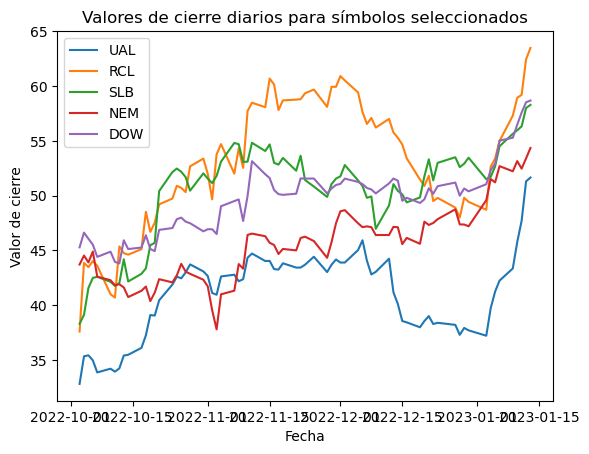

In [146]:
plot3meses(lista_top5_c1)

In [148]:
# Filtrar las filas que están dentro del rango de fechas
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-01-30')
df_stocks_P = df_stocks.loc[(df_stocks['date'] >= start_date) & (df_stocks['date'] <= end_date)]
df_stocks_P.head()

,id,symbol,adj_close,close,high,low,open,volume,id_fecha,year,month,day,date
503,2023_1_3_MMM,MMM,122.470001,122.470001,122.639999,120.370003,121.519997,2612800.0,2023_1_3,2023,1,3,2023-01-03
504,2023_1_4_MMM,MMM,125.150002,125.150002,125.290001,122.709999,123.349998,2769700.0,2023_1_4,2023,1,4,2023-01-04
505,2023_1_5_MMM,MMM,122.959999,122.959999,124.570000,122.459999,124.209999,2606600.0,2023_1_5,2023,1,5,2023-01-05
506,2023_1_6_MMM,MMM,126.720001,126.720001,127.129997,123.750000,124.660004,2417000.0,2023_1_6,2023,1,6,2023-01-06
507,2023_1_9_MMM,MMM,126.790001,126.790001,129.460007,126.110001,127.000000,2871300.0,2023_1_9,2023,1,9,2023-01-09


In [150]:
#Regresion Linear con scikit learn
df_stockstop5_c1_1 = df_stocks_P[df_stocks_P['symbol'] == lista_top5_c1[0]]
df_stockstop5_c1_1.head()

,id,symbol,adj_close,close,high,low,open,volume,id_fecha,year,month,day,date
233463,2023_1_3_UAL,UAL,37.209999,37.209999,38.250000,36.820000,38.220001,8149600.0,2023_1_3,2023,1,3,2023-01-03
233464,2023_1_4_UAL,UAL,39.720001,39.720001,39.849998,37.560001,37.619999,8743700.0,2023_1_4,2023,1,4,2023-01-04
233465,2023_1_5_UAL,UAL,41.240002,41.240002,41.270000,39.430000,39.599998,8292700.0,2023_1_5,2023,1,5,2023-01-05
233466,2023_1_6_UAL,UAL,42.240002,42.240002,42.279999,41.049999,41.410000,7723200.0,2023_1_6,2023,1,6,2023-01-06
233467,2023_1_9_UAL,UAL,43.349998,43.349998,44.189999,42.259998,42.570000,10072200.0,2023_1_9,2023,1,9,2023-01-09


In [153]:
# Dividir el dataframe en conjunto de entrenamiento y prueba
train, test = train_test_split(df_stockstop5_c1_1, test_size=0.3, shuffle=False)

In [179]:
def PredRL(df,fig, symbol):
    plt.figure(fig)
    df = df.sort_values('date')
    train, test = train_test_split(df, test_size=0.3, shuffle=False)
    model = LinearRegression()
    X_train = train['day'].values.reshape(-1, 1)
    y_train = train['close'].values
    X_test = test['day'].values.reshape(-1, 1)
    model.fit(X_train, y_train)
    # Hacer la predicción para los siguientes 5 días
    y_pred = model.predict(X_test)
    X_test = X_test.reshape(-1)
    pred_df = pd.DataFrame({'day': X_test, 'close_pred': y_pred})
    # Graficar los valores de cierre y las predicciones
    plt.plot(df['day'], df['close'], label=symbol)
    plt.plot(pred_df['day'], pred_df['close_pred'], label='pred')
    plt.legend()
    plt.show()

In [181]:
lista_top5_c1[0]

'UAL'

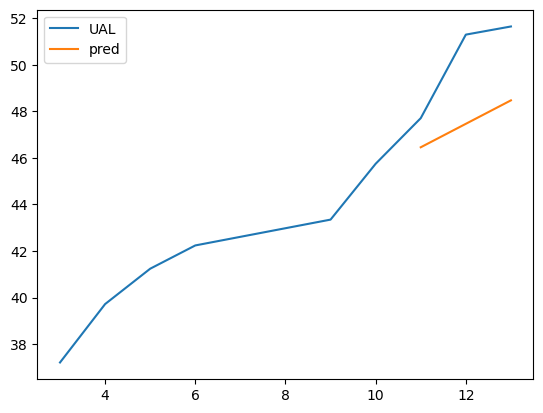

In [180]:
PredRL(df_stockstop5_c1_1,1,lista_top5_c1[0])

In [154]:
model = LinearRegression()
X_train = train['day'].values.reshape(-1, 1)
y_train = train['close'].values
X_test = test['day'].values.reshape(-1, 1)
model.fit(X_train, y_train)

LinearRegression()

In [155]:
X_test

array([[11],
       [12],
       [13]], dtype=int64)

In [103]:
start_date = '2023-01-14'
end_date = '2023-01-18'
date_range = pd.date_range(start=start_date, end=end_date)

In [104]:
start_date = datetime.date(2023, 1, 14)
end_date = datetime.date(2023, 1, 30)
delta = datetime.timedelta(days=1)

date_array = []
while start_date <= end_date:
    date_array.append(start_date.strftime("%Y_%m_%d"))
    start_date += delta
date_array = np.array(date_array)

array(['2023_01_14', '2023_01_15', '2023_01_16', '2023_01_17',
       '2023_01_18', '2023_01_19', '2023_01_20', '2023_01_21',
       '2023_01_22', '2023_01_23', '2023_01_24', '2023_01_25',
       '2023_01_26', '2023_01_27', '2023_01_28', '2023_01_29',
       '2023_01_30', '2023_01_31', '2023_02_01', '2023_02_02',
       '2023_02_03', '2023_02_04', '2023_02_05', '2023_02_06',
       '2023_02_07', '2023_02_08', '2023_02_09', '2023_02_10',
       '2023_02_11', '2023_02_12', '2023_02_13', '2023_02_14',
       '2023_02_15', '2023_02_16', '2023_02_17', '2023_02_18',
       '2023_02_19', '2023_02_20', '2023_02_21', '2023_02_22',
       '2023_02_23', '2023_02_24', '2023_02_25', '2023_02_26',
       '2023_02_27', '2023_02_28', '2023_03_01', '2023_03_02',
       '2023_03_03', '2023_03_04', '2023_03_05', '2023_03_06',
       '2023_03_07', '2023_03_08', '2023_03_09', '2023_03_10',
       '2023_03_11', '2023_03_12', '2023_03_13', '2023_03_14',
       '2023_03_15', '2023_03_16', '2023_03_17', '2023_

In [170]:
# Hacer la predicción para los siguientes 5 días
X_pred = np.array(date_array.reshape(-1, 1))
y_pred = model.predict(X_test)

ValueError: Expected 2D array, got 1D array instead:
array=[11 12 13].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [159]:
y_pred

array([46.45836867, 47.46665177, 48.47493487])

In [167]:
X_test = X_test.reshape(-1)
X_test

array([11, 12, 13], dtype=int64)

In [168]:
pred_df = pd.DataFrame({'day': X_test, 'close_pred': y_pred})
pred_df

,day,close_pred
0,11,46.458369
1,12,47.466652
2,13,48.474935


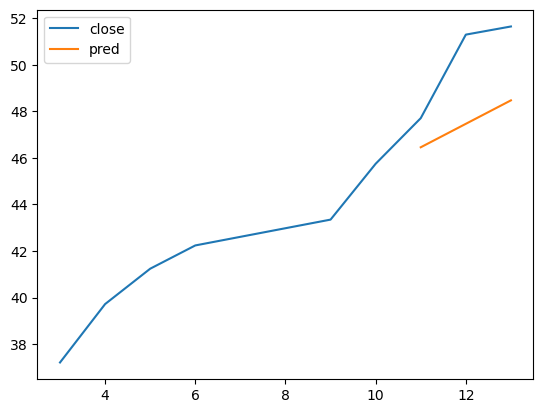

In [169]:
# Graficar los valores de cierre y las predicciones
plt.plot(df_stockstop5_c1_1['day'], df_stockstop5_c1_1['close'], label='close')
plt.plot(pred_df['day'], pred_df['close_pred'], label='pred')
plt.legend()
plt.show()

In [138]:
def PredRL(df,fig):
    plt.figure(fig)
    df = df.sort_values('date')
    df['date'] = pd.to_datetime(df['date'])
    train, test = train_test_split(df, test_size=0.3, shuffle=False)
    model = LinearRegression()
    X_train = train['date'].values.reshape(-1, 1)
    #X_train = pd.to_datetime(X_train) 
    X_test = test['date'].values.reshape(-1, 1)
    #X_test =pd.to_datetime(X_test) 
    y_train = train['close'].values
    model.fit(X_train, y_train)
    # Hacer la predicción para los siguientes 5 días
    #X_pred = np.array(date_array.reshape(-1, 1))
    print(X_test)
    y_pred = model.predict(X_test)
    pred_df = pd.DataFrame({'date': X_test, 'close_pred': y_pred})
    # Graficar los valores de cierre y las predicciones
    plt.plot(df['date'], df['close'], label='close')
    plt.plot(pred_df['date'], pred_df['close_pred'], label='pred')
    plt.legend()
    plt.show()

In [109]:
df_stockstop5_c2_1 = df_stocks[df_stocks['symbol'] == lista_top5_c2[0]]

In [119]:
PredRL(df_stockstop5_c2_1,2)

ValueError: Data must be 1-dimensional

<Figure size 640x480 with 0 Axes>

KeyError: 'day'

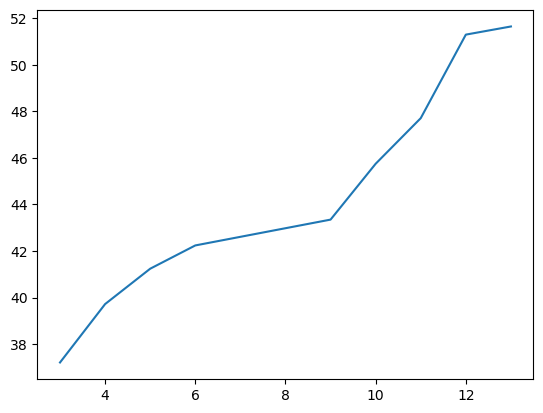

In [173]:
df_stockstop5_c3_1 = df_stocks[df_stocks['symbol'] == lista_top5_c3[0]]
PredRL(df_stockstop5_c1_1,2)